## Unsupervised Seizure Detection
This notebook trains a convolutional autoencoder for anomaly detection using publicly available interictal data. The trained model can then by used for seizure detection on external data. More details can be found in the project [README](README.md).

#### Import Necessary Libraries

In [1]:
# Append "../src/" to the system path to include relevant modules
import sys
sys.path.append("src/")

# Deep learning library
import torch
from models import AnomalyDetector
from datasets import split_data, plot_seizure_scores
from trainer import train, load

# Misc
import warnings

### Define key variables
You can change the following:
* *training_mode* allows you to train a model if set to True, or load a model if set to False.
* *data_path* is the path to the downloaded dataset. This should be changed.
* *weights_path* is the path to the weights. This is used for both saving and loading models. You can leave this as is, and set *training_mode* to False, if you don't need to train a model.

In [2]:
# Train a model, or use an existing one? Change to false if inference only
training_mode = True

# Path to data
data_path = "/Users/jamienorris/ds003876-download/"

# Location for where to save/load best weights (note that folder should be created already)
weights_path = "weights/best_weights.pth"

#### Check Available Computing Resources for Model Training

This section identifies the available computing resources—GPU, MPS (Metal Performance Shader for M1/M2 MacBooks), or CPU—and sets the appropriate device for model training.

* GPU: Utilized if available. Generally offers the fastest training times.
* MPS: Apple's Metal Performance Shaders, available on M1/M2 MacBooks. Utilized if a GPU is not available.
* CPU: Used as a fallback if neither a GPU nor MPS is available.

Make sure you have installed the Metal library if you plan to train on an M1/M2 MacBook. If you have a suitable GPU, it will be automatically selected.

In [3]:
print(f"PyTorch version: {torch.__version__}")

# Check for GPU
is_gpu_available = torch.cuda.is_available()
print(f"Is GPU available? {is_gpu_available}")

# Check for MPS (Metal Performance Shader, Apple's GPU architecture)
is_mps_built = torch.backends.mps.is_built()
is_mps_available = torch.backends.mps.is_available()
print(f"Is MPS (Metal Performance Shader) built? {is_mps_built}")
print(f"Is MPS available? {is_mps_available}")

# Set the device
if is_gpu_available:
    device = "cuda"
elif is_mps_available:
    device = "mps"
else:
    device = "cpu"

print(f"Using device: {device}")

PyTorch version: 2.1.0.dev20230724
Is GPU available? False
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


#### Prepare Data Loaders for Training and Validation
The raw EDF files are processed to retain only the relevant channels, followed by the application of notch and band-pass filters for noise removal. The data is then resampled to 512 Hz (or to the desired sampling frequency, if different). Subsequently, the data is partitioned into training (80%) and validation (20%) sets using the split_data function.
This prepares the DataLoader objects, train_loader and val_loader, which are essential for the training and validation phases of the machine learning model.

In [4]:
with warnings.catch_warnings():
    
    # Suppress warnings about EDF file ("Omitted 11 annotation(s) that were outside data range")
    warnings.simplefilter("ignore", category=RuntimeWarning)
    
    # Create a DataLoader for training/validation data
    train_loader, val_loader = split_data(data_path, pattern="**/ses-extraoperative/ieeg/*.edf")

 15%|█▍        | 8/54 [00:21<02:00,  2.63s/it]

Channels file /Users/jamienorris/ds003876-download/sub-NIH4/ses-extraoperative/ieeg/sub-NIH4_ses-extraoperative_task-interictal_run-01_channels.tsv doesn't appear to match edf file /Users/jamienorris/ds003876-download/sub-NIH4/ses-extraoperative/ieeg/sub-NIH4_ses-extraoperative_task-interictal_run-01_ieeg.edf, proceeding to next iteration. (0.0)


 22%|██▏       | 12/54 [00:27<01:16,  1.82s/it]

Channels file /Users/jamienorris/ds003876-download/sub-NIH2/ses-extraoperative/ieeg/sub-NIH2_ses-extraoperative_task-interictal_run-01_channels.tsv doesn't appear to match edf file /Users/jamienorris/ds003876-download/sub-NIH2/ses-extraoperative/ieeg/sub-NIH2_ses-extraoperative_task-interictal_run-01_ieeg.edf, proceeding to next iteration. (0.0)


 54%|█████▎    | 29/54 [01:09<00:43,  1.76s/it]

Channels file /Users/jamienorris/ds003876-download/sub-NIH7/ses-extraoperative/ieeg/sub-NIH7_ses-extraoperative_task-interictal_run-01_channels.tsv doesn't appear to match edf file /Users/jamienorris/ds003876-download/sub-NIH7/ses-extraoperative/ieeg/sub-NIH7_ses-extraoperative_task-interictal_run-01_ieeg.edf, proceeding to next iteration. (0.0)


 70%|███████   | 38/54 [01:24<00:11,  1.36it/s]

Channels file /Users/jamienorris/ds003876-download/sub-NIH8/ses-extraoperative/ieeg/sub-NIH8_ses-extraoperative_task-interictal_run-01_channels.tsv doesn't appear to match edf file /Users/jamienorris/ds003876-download/sub-NIH8/ses-extraoperative/ieeg/sub-NIH8_ses-extraoperative_task-interictal_run-01_ieeg.edf, proceeding to next iteration. (0.0)


 72%|███████▏  | 39/54 [01:24<00:10,  1.50it/s]

Channels file /Users/jamienorris/ds003876-download/sub-NIH11/ses-extraoperative/ieeg/sub-NIH11_ses-extraoperative_task-interictal_run-01_channels.tsv doesn't appear to match edf file /Users/jamienorris/ds003876-download/sub-NIH11/ses-extraoperative/ieeg/sub-NIH11_ses-extraoperative_task-interictal_run-01_ieeg.edf, proceeding to next iteration. (0.0)


 78%|███████▊  | 42/54 [01:27<00:09,  1.26it/s]

Channels file /Users/jamienorris/ds003876-download/sub-NIH1/ses-extraoperative/ieeg/sub-NIH1_ses-extraoperative_task-interictal_run-01_channels.tsv doesn't appear to match edf file /Users/jamienorris/ds003876-download/sub-NIH1/ses-extraoperative/ieeg/sub-NIH1_ses-extraoperative_task-interictal_run-01_ieeg.edf, proceeding to next iteration. (0.0)


 80%|███████▉  | 43/54 [01:27<00:07,  1.52it/s]

Channels file /Users/jamienorris/ds003876-download/sub-NIH6/ses-extraoperative/ieeg/sub-NIH6_ses-extraoperative_task-interictal_run-01_channels.tsv doesn't appear to match edf file /Users/jamienorris/ds003876-download/sub-NIH6/ses-extraoperative/ieeg/sub-NIH6_ses-extraoperative_task-interictal_run-01_ieeg.edf, proceeding to next iteration. (0.0)


 83%|████████▎ | 45/54 [01:28<00:03,  2.26it/s]

Channels file /Users/jamienorris/ds003876-download/sub-umf005/ses-extraoperative/ieeg/sub-umf005_ses-extraoperative_task-interictalawake_run-01_channels.tsv doesn't appear to match edf file /Users/jamienorris/ds003876-download/sub-umf005/ses-extraoperative/ieeg/sub-umf005_ses-extraoperative_task-interictalawake_run-01_ieeg.edf, proceeding to next iteration. (0.40425531914893614)
Channels file /Users/jamienorris/ds003876-download/sub-umf005/ses-extraoperative/ieeg/sub-umf005_ses-extraoperative_task-interictalasleep_run-01_channels.tsv doesn't appear to match edf file /Users/jamienorris/ds003876-download/sub-umf005/ses-extraoperative/ieeg/sub-umf005_ses-extraoperative_task-interictalasleep_run-01_ieeg.edf, proceeding to next iteration. (0.40425531914893614)


100%|██████████| 54/54 [02:02<00:00,  2.26s/it]


### Create our network
This cell initializes the AnomalyDetector, a convolutional autoencoder designed for seizure detection in SEEG data. The architecture includes encoding and decoding phases that aim to:

1. Encode the original SEEG input through a "bottleneck" to learn a compressed representation of the interictal (baseline) data.
2. Decode this compressed representation back into the original input space.

The underlying principle is that if the network is trained well on interictal data, the difference between the original input and its reconstruction will be minimal for interictal states but significant for ictal (seizure) states. This difference can be quantified using a loss metric like Mean Squared Error (MSE). If the MSE exceeds a predetermined threshold, the input is flagged as ictal or seizure-like.

In [5]:
# Initialize the model and move it to the desired device (CPU/MPS/GPU)
model = AnomalyDetector(input_channels=1).to(device)

### Train or Load the Model

This cell performs one of two tasks based on the _training_mode_ flag:

1. Train the Model: If _training_mode_ is set to True, the AnomalyDetector model is trained using the provided training and validation datasets. During each epoch, the model processes input batches and aims to minimize the Mean Squared Error (MSE) between the input and reconstructed output. Following each epoch, the model's performance is evaluated on the validation set using MSE as the metric. Training will halt if the validation MSE does not decrease for 5 consecutive epochs.
2. Load Pre-trained Model: If _training_mode_ is set to False, a pre-trained model is loaded from a checkpoint specified by weights_path.

The model, after either being trained or loaded, is then returned for further use.

In [6]:
# Train the model using the training and validation datasets if 'training_mode' is True; otherwise, load a pre-trained model from 'weights_path'
model = train(train_loader, val_loader, model, device, weights_path) if training_mode else load(model, weights_path)

### Visualize Seizure Detection Metrics

This cell performs the following tasks:

1. Specifies the path to an iEEG file containing seizure data.
2. Calls the plot_seizure_scores function to process the data and calculate the Mean Squared Error (MSE) for each second of each channel.
3. Visualizes these MSE scores, aiming to highlight periods likely corresponding to seizures. Bright spots in the visualization are expected to be indicative of seizure activity.

/Users/jamienorris/Documents/Seizure-detection/src/datasets.py:209: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw_interictal = mne.io.read_raw_edf(raw_interictal_file, preload=True, verbose=False)
/Users/jamienorris/Documents/Seizure-detection/src/datasets.py:215: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(seizure_file, preload=True, verbose=False)


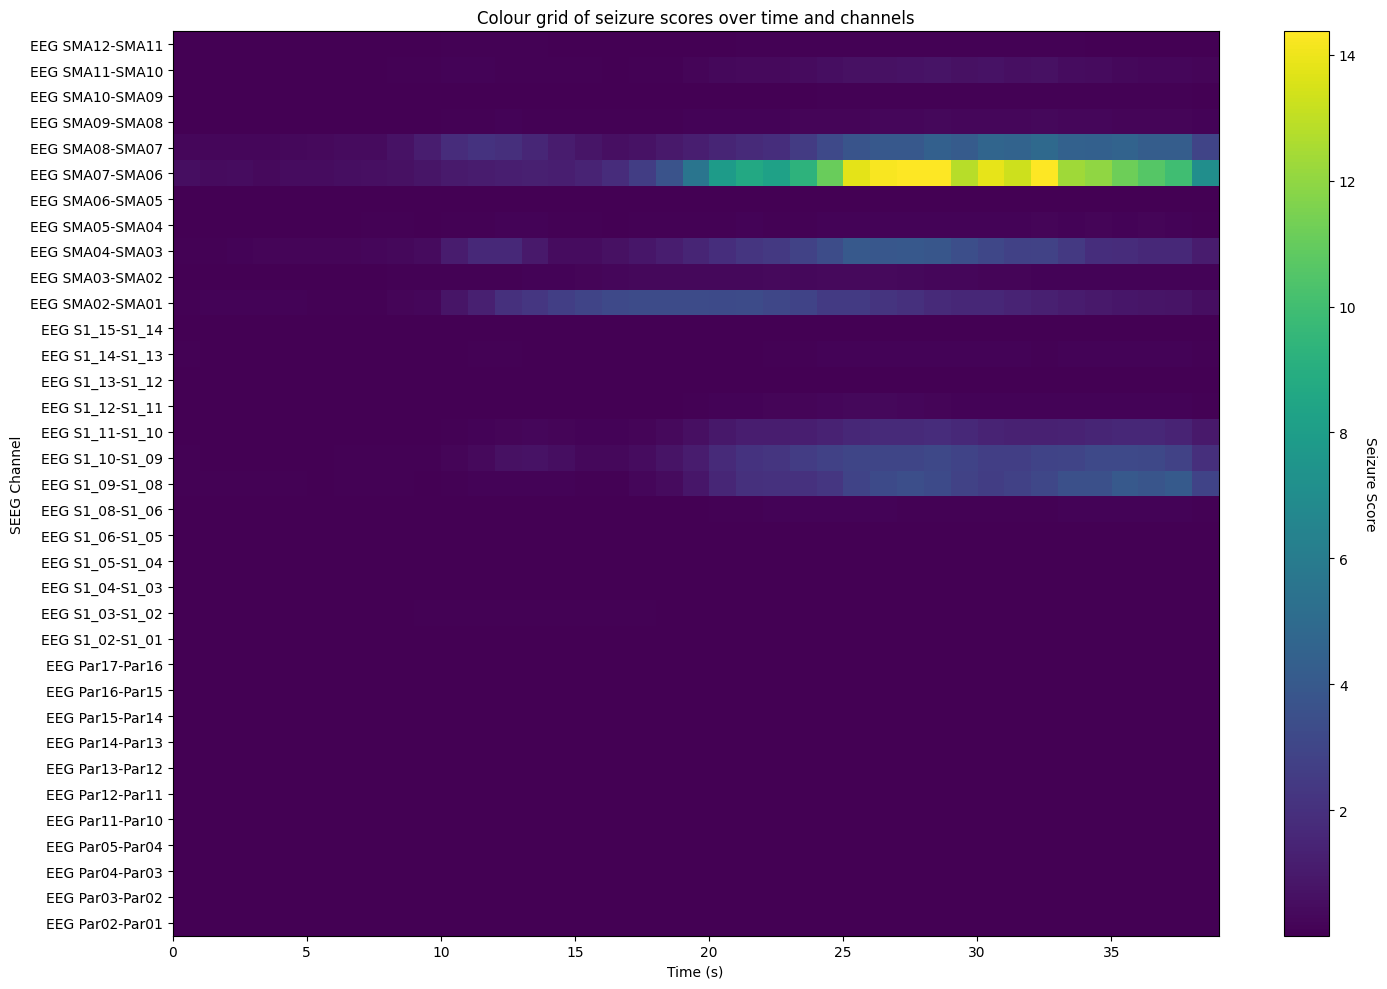

In [8]:
# Path to the seizure data file in EDF format (Note that the code assumes this is 50Hz)
patient_seizure_path = "/path/to/seizure.EDF"

# Visualize Mean Squared Error (MSE) scores for the provided seizure data
plot_seizure_scores(patient_seizure_path, model, device, standardise=True, window_size=3, save_path="images/seizure_viz.png")